## CONTEXTO

Este estudo de caso tem como objetivo construir um modelo de regressão para prever o preço de imóveis com base em características como área, número de quartos, mobília e proximidade da via principal. Apesar do conjunto de dados ser pequeno, o desafio está na forte multicolinearidade entre as variáveis, que pode afetar a precisão e interpretação do modelo. O foco será explorar os dados, identificar e tratar essa multicolinearidade, e desenvolver um modelo preditivo eficiente e interpretável.

In [35]:
# Carregando pacotes
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import networkx as nx
import matplotlib.cm as cm
from statstests.process import stepwise
from scipy.stats import norm
from scipy.stats import boxcox
sys.path.append('../src')
from utils import iqr
from utils import shapiro_test
from model import modelo_reg

In [2]:
# Importando os dados
df_housing = pd.read_csv('../Data/raw/Housing.csv')

In [3]:
df_housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [4]:
df_housing.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

## Dicionario de dados 

| Variável               | Tradução      | Descrição                                      |
|------------------------|-------------|------------------------------------------------|
| price                   | Preço    | Preço das Casas       |
| area               | área   | área da casa                          |
| bedrooms              | quartos  | Quantidade de quartos    |
| bathrooms | banheiros  | Quantidade de banheiros |
| stories                | Andares   | Número de Andares                |
| mainroad                | Estrada Principal    | Casa conectada a uma estrada principal ?                |
| guestroom                | Quarto de Hóspedes    | Possui quarto de hóspedes ?                |
| basement                | Porão   | Possui porão ?                |
| hotwaterheating                | Aquecedor de água quente    | Possui aquecedor de água quente ?                |
| airconditioning                | Ar condicionado    | Possui ar condicionado ?                 |
| parking                | Estacionamento    | Número de vagas de estacionamento              |
| prefarea                | Área Valorizada ?    | Indica se o imóvel está localizado em área valorizada ou desejada                |
| furnishingstatus                | Situação mobiliaria da casa  | Está monbiliada ?             |

In [5]:
# Verificando o tamanho do DataFrame
df_housing.shape


(545, 13)

In [6]:
# Verificando os tipos das variáveis
df_housing.dtypes

price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object

In [7]:
# Verificando a existência de dados ausentes
df_housing.isnull().sum()/len(df_housing)*100

price               0.0
area                0.0
bedrooms            0.0
bathrooms           0.0
stories             0.0
mainroad            0.0
guestroom           0.0
basement            0.0
hotwaterheating     0.0
airconditioning     0.0
parking             0.0
prefarea            0.0
furnishingstatus    0.0
dtype: float64

In [8]:
df_housing.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


Como o principal foco deste estudo é a variável price - preço das residências, a análise exploratória será direcionada especialmente a ela. A partir deste ponto, buscaremos identificar padrões, relações e possíveis tendências que possam influenciar diretamente os valores dos imóveis.

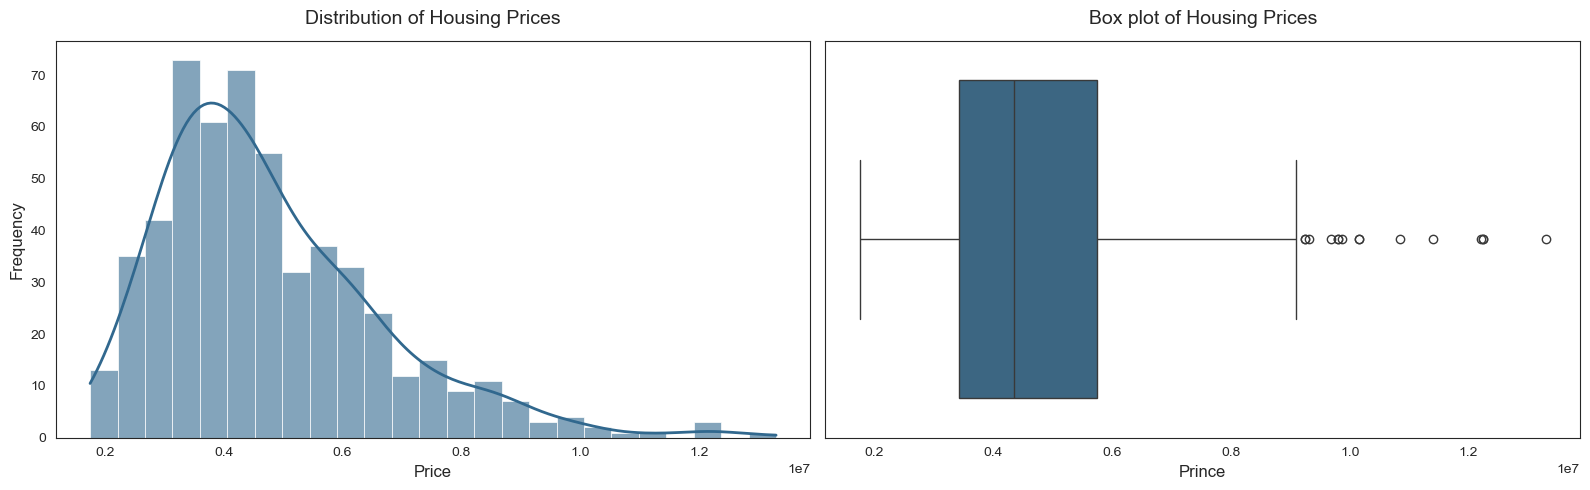

In [9]:
sns.set_style('white')
palette = sns.color_palette("viridis", 2)  
fig, axes = plt.subplots(1,2, figsize=(16,5))

# histograma
hist = sns.histplot(
    df_housing['price'],
    kde=True,
    bins=25,
    ax=axes[0],
    color=palette[0],          
    alpha=0.6,
    edgecolor="white",
    linewidth=0.5,
    line_kws={"linewidth": 2, "color": palette[1]},
    
)
axes[0].set_xlabel("Price", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)
axes[0].set_title("Distribution of Housing Prices", fontsize=14, pad=12)

box_plot = sns.boxplot(
    x=df_housing['price'],
    color=palette[0],
    ax=axes[1]
)

axes[1].set_title('Box plot of Housing Prices', fontsize=14, pad=12)
axes[1].set_xlabel('Prince', fontsize=12)


plt.tight_layout()
plt.show()

Pelos gráficos gerados acima, nota-se que a variável price que representa o preço dos imóveis apresenta uma distribuição assimétrica à direita, logo a maior parte dos dados está concentrada à esquerda da distribuição com calda longa estendendo-se à direita.
 - A faixa de preço com maior frequência está entre aproximadamente 3 e 4,5 milhores, indicando que essa é faixa mais comum para valores de imóveis no respectivo dataset
 - Existe a presença de valores outliers, valores que podem indicar residências de alto padrão ou alta classificação

In [10]:
# Top 15 residências mais caras
sup, inf = iqr(df_housing, 'price')
df_housing[df_housing['price'] > sup]

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
5,10850000,7500,3,3,1,yes,no,yes,no,yes,2,yes,semi-furnished
6,10150000,8580,4,3,4,yes,no,no,no,yes,2,yes,semi-furnished
7,10150000,16200,5,3,2,yes,no,no,no,no,0,no,unfurnished
8,9870000,8100,4,1,2,yes,yes,yes,no,yes,2,yes,furnished
9,9800000,5750,3,2,4,yes,yes,no,no,yes,1,yes,unfurnished


## Verificando a relação entre o preço e outras variáveis


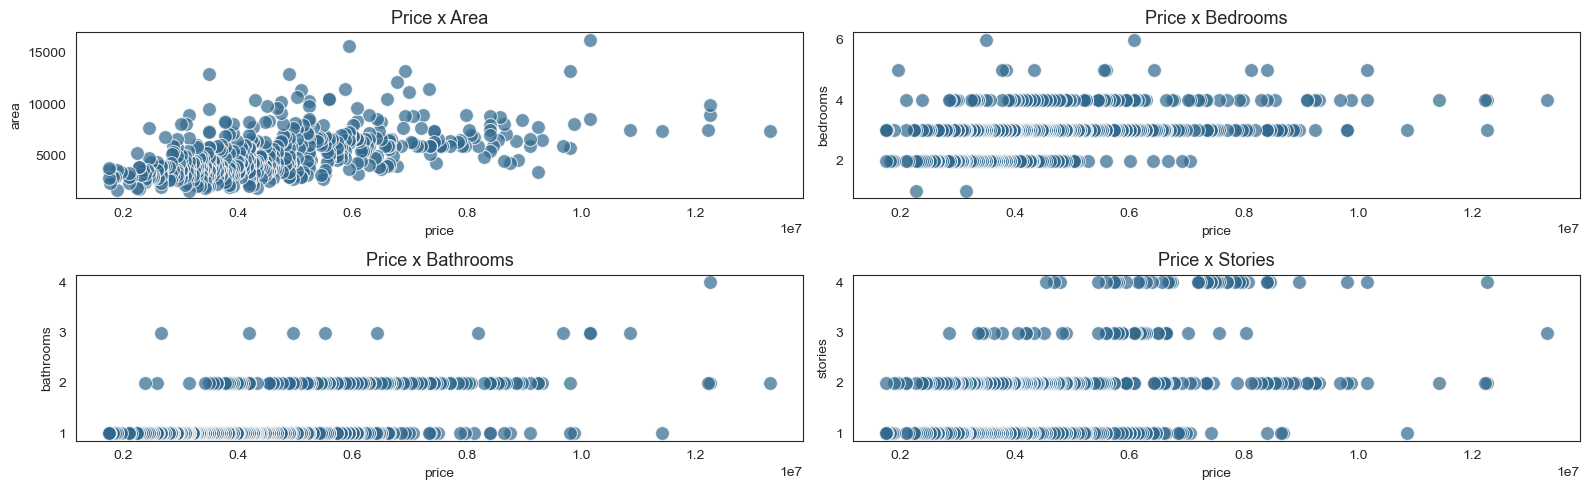

In [11]:
sns.set_style('white')
palette = sns.color_palette("viridis", 2)  
fig,axes = plt.subplots(2,2, figsize=(16,5))

# price x area
sns.scatterplot(x='price', y='area', data=df_housing, s=100, alpha=0.7, ax=axes[0,0], color=palette[0])
axes[0,0].set_title('Price x Area', fontsize=13)

# price x bedrooms
sns.scatterplot(x='price', y='bedrooms', data=df_housing, s=100, alpha=0.7, ax=axes[0,1], color=palette[0])
axes[0,1].set_title('Price x Bedrooms', fontsize=13)

# price x bathrooms
sns.scatterplot(x='price', y='bathrooms', data=df_housing, s=100, alpha=0.7, ax=axes[1,0], color=palette[0])
axes[1,0].set_title('Price x Bathrooms', fontsize=13)

# price x stories
sns.scatterplot(x='price', y='stories', data=df_housing, s=100, alpha=0.7 ,ax=axes[1,1], color=palette[0])
axes[1,1].set_title('Price x Stories', fontsize=13)

plt.tight_layout()
plt.show()

Gráficos:
- Preço x Área: nota-se um padrão ascendente, logo conforme a área aumenta o preço tende a subir.
- Preço x Bathrooms / Bedrooms / Stories: os gráficos se mostram dispersos, sem uma tendência linear clara.

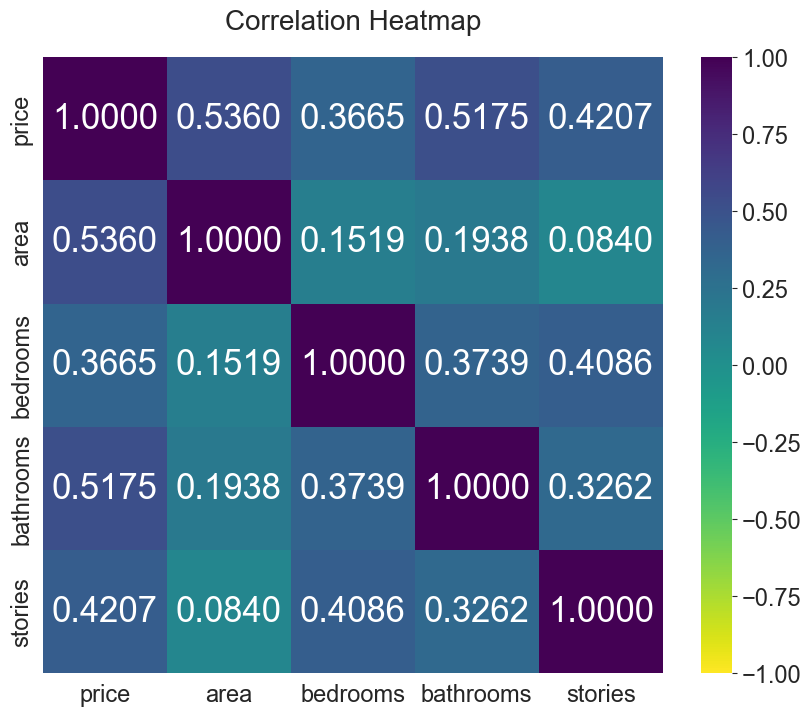

In [12]:
# Correlação entre todas as variáveis quantitativas
correlation_matrix = df_housing[['price', 'area', 'bedrooms', 'bathrooms', 'stories']].corr()


plt.figure(figsize=(10,8))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".4f",
                      cmap=plt.cm.viridis_r,
                      annot_kws={'size': 25}, vmax=1, vmin=-1)

heatmap.set_title('Correlation Heatmap', fontsize=20, pad=20)
heatmap.set_xticklabels(heatmap.get_xticklabels(),fontsize=17)
heatmap.set_yticklabels(heatmap.get_yticklabels(),fontsize=17)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.show()

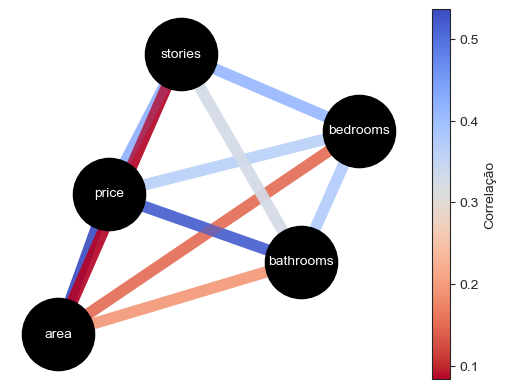

In [13]:
correlation_matrix = df_housing[['price', 'area', 'bedrooms', 'bathrooms', 'stories']].corr()
G = nx.DiGraph()

for variable in correlation_matrix.columns:
    G.add_node(variable)

for i, variable1 in enumerate(correlation_matrix.columns):
    for j, variable2 in enumerate(correlation_matrix.columns):
        if i != j:
            correlation = correlation_matrix.iloc[i,j]
            if abs(correlation)> 0:
                G.add_edge(variable1, variable2, weight=correlation)

correlations = [d['weight'] for _, _, d in G.edges(data=True)]

node_size=2700
node_color = 'black'
cmap = plt.colormaps.get_cmap('coolwarm_r')

edge_widths = [abs(correlation) * 25 for _,_,d in G.edges(data=True)]

pos = nx.spring_layout(G, k=0.75)
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=correlations, edge_cmap=cmap, alpha=0.7)

labels = {node: node for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color='white')

ax = plt.gca()
ax.margins(0.1)
plt.axis("off")

smp = cm.ScalarMappable(cmap=cmap)
smp.set_array([min(correlations), max(correlations)])
cbar = plt.colorbar(smp, ax=ax, label='Correlação')

plt.show()

De acordo com o input do dois gráficos gerados acima há correlação entre as variáveis que podem ser descritas como:
- Price x area = correlação moderada de 0,5
- Price x stories = correlação moderada de 0,4

Mesmo que baixa há indicios de correlação entre as variáveis explicativas que farão parte do modelo como em bedrooms x stories e bedrooms x bathrooms será realizado estudo para verificação a presença de multicolinearidade entre as variávei explicativas.

Multicolinearidade ocorre quando duas ou mais variáveis independentes em um modelo de regressão estão altamente correlacionadas entre si. Isso dificulta a estimativa precisa dos coeficientes, tornando os resultados instáveis e comprometendo a interpretação individual de cada variável.

In [14]:
# processo de dummização das variáveis categóricas
df_housing_dummies = pd.get_dummies(df_housing,
                                    columns=['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus'],
                                    drop_first= True,
                                    dtype = int)

In [15]:
df_housing_dummies.rename(columns=lambda x: x.replace('-', '_'), inplace=True)
lista_colunas = list(df_housing_dummies.drop(columns=['price']).columns)
modelo = ' + '.join(lista_colunas)

modelo = 'price ~ ' + modelo

reg = modelo_reg(modelo, df_housing_dummies)


In [16]:
print('Parametros do modelo:')
reg.summary()

Parametros do modelo:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     87.52
Date:                Mon, 21 Jul 2025   Prob (F-statistic):          9.07e-123
Time:                        22:53:01   Log-Likelihood:                -8331.5
No. Observations:                 545   AIC:                         1.669e+04
Df Residuals:                     531   BIC:                         1.675e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        4.277e+04   2.64e+05      0.162      0.872   -4.76e+05    5.62e+05
area                              244.1394     24.289     10.052      0.000     196.425     291.853
bedrooms                         1.148e+05   7.26e+04      1.581      0.114   -2.78e+04    2.57e+05
bathrooms                        9.877e+05   1.03e+05      9.555      0.000    7.85e+05    1.19e+06
stories                          4.508e+05   6.42e+04      7.026      0.000    3.25e+05    5.77e+05
parking                          2.771e+05   5.85e+04      4.735      0.000    1.62e+05    3.92e+05
mainroad_yes                     4.213e+05   1.42e+05      2.962      0.003    1.42e+05    7.01e+05
guestroom_yes                    3.005e+05   1.32e+05      2.282      0.023    4.18e+04    5.59e+05
basement_yes                     3.501e+05    1.1e+05      3.175      0.002    1.33e+05    5.67e+05
hotwaterheating_yes              8.554e+05   2.23e+05      3.833      0.000    4.17e+05    1.29e+06
airconditioning_yes               8.65e+05   1.08e+05      7.983      0.000    6.52e+05    1.08e+06
prefarea_yes                     6.515e+05   1.16e+05      5.632      0.000    4.24e+05    8.79e+05
furnishingstatus_semi_furnished -4.634e+04   1.17e+05     -0.398      0.691   -2.75e+05    1.83e+05
furnishingstatus_unfurnished    -4.112e+05   1.26e+05     -3.258      0.001   -6.59e+05   -1.63e+05
==============================================================================
Omnibus:                       97.909   Durbin-Watson:                   1.209
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              258.281
Skew:                           0.895   Prob(JB):                     8.22e-57
Kurtosis:                       5.859   Cond. No.                     3.49e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Insights Modelo inicial
- R²: indica que 68% da variância da variável predita é explicado pelo comportamento das variáveis preditoras
- P - F-Statistic < 0,05, logo pode-se afirmar que existe modelo
- T-Statistic: avalia individualmente cada variável para definir se é estatísticamente signigicante para o modelo, P-valor > 0.05 podemos afirmar que o parâmetro não é significante para o modelo. No modelo inicial nota-se que a variável furnishingstatus_semi_furnished e bedrooms não se mostraram significantes.

In [17]:
# Aplicando Step-Wise para remoção das variáveis não significantes
reg_step = stepwise(reg, pvalue_limit=0.05)

Regression type: OLS 

Estimating model...: 
 price ~ Q('area') + Q('bedrooms') + Q('bathrooms') + Q('stories') + Q('parking') + Q('mainroad_yes') + Q('guestroom_yes') + Q('basement_yes') + Q('hotwaterheating_yes') + Q('airconditioning_yes') + Q('prefarea_yes') + Q('furnishingstatus_semi_furnished') + Q('furnishingstatus_unfurnished')

 Discarding atribute "Q('furnishingstatus_semi_furnished')" with p-value equal to 0.6911179481974057 

Estimating model...: 
 price ~ Q('area') + Q('bedrooms') + Q('bathrooms') + Q('stories') + Q('parking') + Q('mainroad_yes') + Q('guestroom_yes') + Q('basement_yes') + Q('hotwaterheating_yes') + Q('airconditioning_yes') + Q('prefarea_yes') + Q('furnishingstatus_unfurnished')

 Discarding atribute "Q('bedrooms')" with p-value equal to 0.11524040932679282 

Estimating model...: 
 price ~ Q('area') + Q('bathrooms') + Q('stories') + Q('parking') + Q('mainroad_yes') + Q('guestroom_yes') + Q('basement_yes') + Q('hotwaterheating_yes') + Q('airconditioning_yes')

In [19]:
# Verificação do termos de erros a normalidade com o teste Shapiro-Francia
shapiro_test(reg_step)

method  :  Shapiro-Francia normality test
statistics W  :  0.9502033592078699
statistics z  :  6.54077657222417
p-value  :  3.060010244713559e-11
Statistics_W=0.95020, p-value=0.000000
Rejeita-se H0 - Distribuição não aderente à normalidade


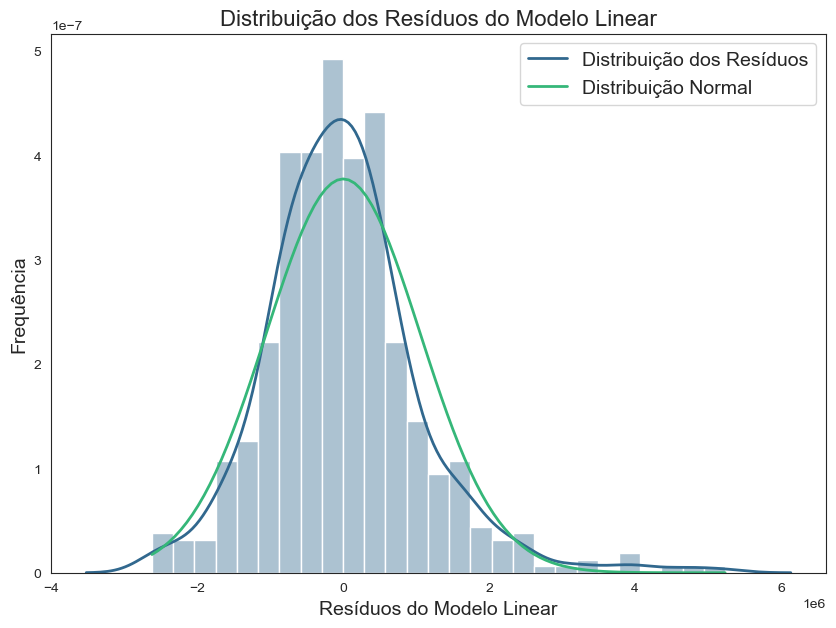

In [33]:
(mu, sigma) = norm.fit(reg_step.resid)

sns.set_style('white')
palette = sns.color_palette("viridis", 2)  
plt.figure(figsize=(10,7))
sns.histplot(reg_step.resid, color=palette[0], stat='density', alpha=0.4)
sns.kdeplot(reg_step.resid, color=palette[0], linewidth=2, label='Distribuição dos Resíduos')
x= np.linspace(min(reg_step.resid), max(reg_step.resid), 100)
plt.plot(x, norm.pdf(x, mu, sigma), color=palette[1], linewidth=2, label='Distribuição Normal')
plt.legend(fontsize=14)
plt.xlabel('Resíduos do Modelo Linear', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.title('Distribuição dos Resíduos do Modelo Linear', fontsize=16)
plt.show()

A distribuição dos resíduos, juntamente com o resultado do teste de Shapiro-Francia, indica que os resíduos do modelo não seguem uma distribuição normal. Diante disso, será aplicada a transformação de Box-Cox à variável price, com o objetivo de aproximar a distribuição dos resíduos da normalidade.

In [ ]:
# Transformação Box-Cox
yast, lmbda = boxcox(df_housing_dummies['price'])

df_housing_dummies['price_bc'] = yast
del df_housing_dummies['price']

In [ ]:
# Aplicando o novo modelo com a variável transformada
lista_colunas = list(df_housing_dummies.drop(columns=['price_bc']).columns)
modelo = ' + '.join(lista_colunas)
modelo = 'price_bc ~ ' + modelo

modelo_bc = modelo_reg(modelo, df_housing_dummies)

In [42]:
modelo_bc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               price_bc   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     92.91
Date:                ter, 22 jul 2025   Prob (F-statistic):          1.83e-127
Time:                        21:45:25   Log-Likelihood:                 1213.3
No. Observations:                 545   AIC:                            -2399.
Df Residuals:                     531   BIC:                            -2338.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           6.3592      0.007    971.123      0.000       6.346       6.372
area                             6.266e-06   6.02e-07     10.414      0.000    5.08e-06    7.45e-06
bedrooms                            0.0038      0.002      2.133      0.033       0.000       0.007
bathrooms                           0.0201      0.003      7.843      0.000       0.015       0.025
stories                             0.0114      0.002      7.156      0.000       0.008       0.014
parking                             0.0055      0.001      3.803      0.000       0.003       0.008
mainroad_yes                        0.0154      0.004      4.378      0.000       0.009       0.022
guestroom_yes                       0.0089      0.003      2.725      0.007       0.002       0.015
basement_yes                        0.0116      0.003      4.264      0.000       0.006       0.017
hotwaterheating_yes                 0.0205      0.006      3.704      0.000       0.010       0.031
airconditioning_yes                 0.0221      0.003      8.236      0.000       0.017       0.027
prefarea_yes                        0.0160      0.003      5.572      0.000       0.010       0.022
furnishingstatus_semi_furnished     0.0027      0.003      0.948      0.344      -0.003       0.008
furnishingstatus_unfurnished       -0.0144      0.003     -4.617      0.000      -0.021      -0.008
==============================================================================
Omnibus:                        6.940   Durbin-Watson:                   1.283
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                7.316
Skew:                          -0.204   Prob(JB):                       0.0258
Kurtosis:                       3.394   Cond. No.                     3.49e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
reg_step_bc = stepwise(modelo_bc, pvalue_limit=0.05)

Regression type: OLS 

Estimating model...: 
 price_bc ~ Q('area') + Q('bedrooms') + Q('bathrooms') + Q('stories') + Q('parking') + Q('mainroad_yes') + Q('guestroom_yes') + Q('basement_yes') + Q('hotwaterheating_yes') + Q('airconditioning_yes') + Q('prefarea_yes') + Q('furnishingstatus_semi_furnished') + Q('furnishingstatus_unfurnished')

 Discarding atribute "Q('furnishingstatus_semi_furnished')" with p-value equal to 0.34351251063319754 

Estimating model...: 
 price_bc ~ Q('area') + Q('bedrooms') + Q('bathrooms') + Q('stories') + Q('parking') + Q('mainroad_yes') + Q('guestroom_yes') + Q('basement_yes') + Q('hotwaterheating_yes') + Q('airconditioning_yes') + Q('prefarea_yes') + Q('furnishingstatus_unfurnished')

 No more atributes with p-value higher than 0.05

 Atributes discarded on the process...: 

{'atribute': "Q('furnishingstatus_semi_furnished')", 'p-value': 0.34351251063319754}

 Model after stepwise process...: 
 price_bc ~ Q('area') + Q('bedrooms') + Q('bathrooms') + Q('sto

Ao realizar o processo de step-wise no modelo box-cox nota-se a permanência da variável bedrooms(Número de quartos) não presente no modelo inicial

